# How to measure posterior performance and fix calibration

This notebook shows how to measure the performance of posterior probabilities for a test dataset, including the overall performance assessed with expected proper scoring rules (EPSRs) like the cross-entropy, and calibration performance assessed with calibration loss. When calibration is poor, the calibration transform trained to compute calibration loss can be added as a new stage in your system to improve the quality of the posteriors.

This is a basic and simple analysis that should always be done when developing classification systems when the scores are meant to be interpretable or used for decision making with Bayes decision theory.

The first few blocks explain the process in detail. The last block has a summary of all the steps from the previous blocks. Once you have the scores and targets loaded up, all you need are a handfull of lines of code.

In [1]:
import numpy as np
from expected_cost import utils
from expected_cost.data import create_scores_for_expts
from expected_cost.calibration import calibration_with_crossval, calibration_train_on_heldout
from expected_cost.psrcal_wrappers import Brier, LogLoss
from psrcal.calibration import AffineCalLogLoss, AffineCalBrier, HistogramBinningCal



## Note on the input scores

This notebook assumes the scores are log-posteriors NOT posteriors. This is to avoid numerical issues when taking the exponential. 

If your model outputs posteriors, you can take the logarithm. If you happen to have some
posteriors=0, this will give infinite and you won't be able to run the methods below. In that case,
you can replace those zeroes by some very small number. Ideally, though, you should have your model
directly output log-posteriors. 

Below we cover how to get the log-posteriors from some common model outputs

### Preactivations from a softmax DNN layer

If your model outputs pre-activations from a DNN which has softmax activation in the last layer,
you'll need to apply log-softmax to get the log-posteriors. Ideally, do not do this by doing
log(softmax). Rather, use the log_softmax method from scipy or some equivalent method, to avoid
numerical problems.

### Log-likelihood ratios

If your model outputs log-likelihood-ratios (like the PLDA models used for speaker or face
verification), then to get the log-posteriors you can do:

```
scores = utils.llrs_to_logpost(preactivations, priors)
```

where the $\mathrm{priors} = [p_1,\ p_2]$ are the priors you expect to see when you deploy the
system, which may or may not coincide with the class frequencies in your test data. Note that, if they do not coincide, 
you also need to set the ```deploy_priors``` variable, as explained below.

If you are considering different costs for each type of error, as usually done in speaker
verification, this is equivalent to changing the priors. In that case you can take the priors above
to be $[1-p_{e},\ p_{e}]$ with 

$$p_{e} = \frac{c_{12}\ p_1}{(c_{12}\ p_1 + c_{21}\ p_2)}$$

where $p_1$ and $p_2$ are the priors we expect to see at deployment and $c_{ij}$ is the cost for deciding 
class $j$ when the true class was $i$.

### Preactivations from a sigmoid DNN layer

If your model outputs pre-activations from a DNN which has sigmoid activation in the last layer,
those values correspond to $\log(p/(1-p))$, where $p$ is the posterior for one of the classes (the one you are using as target). To get the posteriors you can use the following line:

```
scores = utils.llrs_to_logpost(preactivations, [1,1]) 
```

### Support vector machines

If you are working with SVM scores, you need to use the distances to the hyperplane as
scores.


## Load and format the data

The first step is to get the test set and, optionally, a held-out set, into the format required for the next steps.

For this notebook we create the scores using a Gaussian model. 
If you want to use this for your own data, you need to get the scores and the targets in the same format as below and the rest of the code should work without changes.

* **Scores**: numpy array with shape N x K, where N is the number of samples and K is the number of classes. As explained above, the **scores should be log posteriors**. This is very important since the methods for metric calculation and for calibration  assume this is the case. 

* **Targets**: numpy array of N integers between 0 and K-1 indicating the label of each sample.
  
We will always have some test data, with its corresponding scores and targets, `scores_tst` and `targets_tst`. Further, in some cases, we might also have some held-out data which we can use for training the calibration transform. We will call those variables `scores_trn` and `targets_trn`.

### Warnings

* The training data for the calibration transform should not be extracted from the data used to train the classifier. The scores on the data used to train the classifier will likely be optimistically biased and, hence, not a good representation of the scores we will get on unseen data. If all the data available was either already used to train the classifier (and you have no chance of retraining it after leaving some data out for calibration) or is part of the test set, you may consider holding out some of the test data for this purpose. Alternatively, if that is not an option, either because the test set is too small or because you have prior results on the full test set that you want to be able to compare against, then doing cross-validation is your best option.

* While we include train-on-test results below, we suggest never to do this on small test sets and/or when the number of classes is relatively large, in which cases overfitting of the calibration transform needed to compute calibration metrics is extremely likely. Note that this is true for any calibration metric, not just calibration loss. All calibration metrics need to train a calibration transform (parametric or non-parametric) either implicitly or explicitly. 



In [2]:
# Create some simulated data. You can change this cell to load your own data as long as in the end
# you have defined scores_tst and target_tst, and, optionally, scores_trn and targets_trn.

# You can play with the parameters below to create data for different number of classes (K),
# different priors (P0), different number of samples (N), and different difficulty (std).
P0 = 0.9
N = 10000
K = 2
std = 0.15

# The method below creates a bunch of different scores, all with the same targets and puts them in
# score_dict.
score_dict, targets = create_scores_for_expts(K, P0=P0, feat_std=0.15, N=N)

# You can use different scores from the scores_dict:

# Well-calibrated ones:
# scores = score_dict['cal']['Datap'] 

# Miscalibrated due to scaling in the logit domain
# scores = score_dict['mc2']['Datap'] 

# Miscalibrated due to mismatched priors between training and test data
# scores = score_dict['cal']['Mismp'] 

# Miscalibrated for both reasons
scores = score_dict['mc2']['Mismp'] 

# Split that data into tst and trn. If you have two separate sets, you can just load them directly
# into their corresponding variables. You can also leave the trn scores as None and do train-on-test
# or cross-validation. 

shuf = np.arange(len(targets)-1)
np.random.shuffle(shuf)
scores = scores[shuf]
targets = targets[shuf]

N_tst = int(N/2)
scores_tst = scores[:N_tst]
scores_trn = scores[N_tst:]

targets_tst = targets[:N_tst]
targets_trn = targets[N_tst:]

# Finally, when doing cross-validation to get the calibrated scores, we might want to create the
# folds by condition. The condition is any factor other than the class that might create
# correlations between the samples (eg, the speaker if you are doing emotion detection, or the
# patient in medical imaging). In that case, you just need to define an array where you indicate the
# condition of each sample in scores_tst as an index. This array will be used when doing
# cross-validation. If you leave conditions_tst as None, it will do the standard cross-validation,
# splitting into folds by sample.
condition_ids = None


In [3]:
# If scores_trn is not defined (because you changed the cell above and you do not have held-out data
# for training calibration), set it to be scores_tst. This simplifies the code below, avoiding lots
# of ifs for the case in which scores_trn is None. By doing this assignment we can implement 
# test-on-train using the same code as the case that uses held-out data for training.

if scores_trn is None:
    scores_trn = scores_tst
    targets_trn = targets_tst

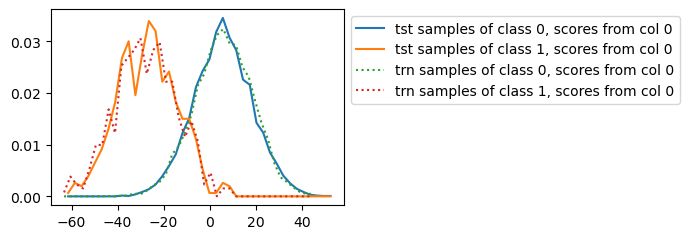

In [4]:
# Plot the distributions as a sanity check, to verify that things look OK and that trn and tst
# distributions are reasonably similar. Ideally, each of the plotted curves should be unimodal and
# somewhat Gaussian. In that scenario, everything we will do below should work quite well. If that
# is not the case (very non-Gaussian or multi-modal per-class per-score distributions) then the
# affine calibration model may not be great and you might want to explore other options in the
# literature. You should probably still use the affine transform as baseline, though, since even 
# in those cases we have seen it produce reasonably calibrated scores.

# Instead of plotting log-posteriors which do not look great and are redundant (since the posteriors
# sum to 1), we plot log(P_i)-log(P_{K-1}), for i=0,...,K-2. 

log_odds_tst = scores_tst[:,:-1]-scores_tst[:,-1][:,np.newaxis]
log_odds_trn = scores_trn[:,:-1]-scores_trn[:,-1][:,np.newaxis]

# We plot the distribution for samples of each class and each of the columns in the log odds. For
# binary classification there's only two distributions so we plot them together. For multi-class
# classification it makes more sense to group the distributions by score.
group_by = 'all' if K==2 else 'target'

axs = utils.plot_hists(targets_tst, log_odds_tst, nbins=40, group_by=group_by, style='-', label_prefix='tst ')
axs = utils.plot_hists(targets_trn, log_odds_trn, nbins=40, group_by=group_by, style=':', label_prefix='trn ', axs=axs)

# If you are curious about how the posteriors look like, simply uncomment this:
# axs = utils.plot_hists(targets_tst, np.exp(scores_tst), nbins=40, group_by=group_by, style='-', label_prefix='tst ')
# axs = utils.plot_hists(targets_trn, np.exp(scores_trn), nbins=40, group_by=group_by, style=':', label_prefix='trn ', axs=axs)
# As you can see those plots are not as nice the log_odds ones. 

# You can also plot the log posteriors, which look better than the posteriors, but do not have the 
# satisfying gaussian distributions.
# axs = utils.plot_hists(targets_tst, scores_tst, nbins=40, group_by=group_by, style='-', label_prefix='tst ')
# axs = utils.plot_hists(targets_trn, scores_trn, nbins=40, group_by=group_by, style=':', label_prefix='trn ', axs=axs)



## Measure overall performance using a normalized EPSR

We can now compute some normalized EPSR (cross-entropy or Brier, in our example). If this value is larger than 1, we already know we should be able to improve the posteriors through calibration (eg, by transforming the scores with some function trained to minimize the EPSR), at the very least by mapping them to the priors. If the value is smaller than 1, we know that the posteriors are informative, yet we might be able to do better. But we will look at that in the next cell. For now, let's just measure the overall performance of our posteriors.


In [5]:
# Expected LogLoss is cross-entropy. This is the most standard general purpose EPSR. You can also try 
# Brier. Yet, as we show in a separate notebook, for problems in which we might end up using extreme
# thresholds on the posteriors (for example, in a medical scenario where errors in one class are
# much more costly than errors in another class), Brier score may not be a great choice since it
# does not adequately penalize extreme errors in the posteriors. 

metric = LogLoss 
# If you want to try Brier:
# metric = Brier

# Finally, if the priors in your held-out and test data are not the ones you expect to see at
# deployment, set the deploy_priors variable to the ones you expect to see in practice. Else, leave
# it as None in which case, the code will compute them from the data.
deploy_priors = None 

overall_perf = metric(scores_tst, targets_tst, priors=deploy_priors, norm=True)

print(f"Overall performance ({metric.__name__}) = {overall_perf:4.2f}" )

Overall performance (LogLoss) = 7.33


## Calibrate the test scores

This is the step that depends on whether you have some held-out data for training the calibrator or not. 
First, it is important to remember that the data we use to train the calibration transform should not have been used for training the classifier that is producing the posteriors, since the posteriors on that data will likely be very good. In particular, if the model was trained with cross-entropy as objective function, the posteriors on the training data will be perfectly or close to perfectly calibrated. Yet, this may not be the case on unseen data. 

There are three typical data scenarios:

1. You have your test set and some held-out set you have not used for training. You might have used it for hyperparameter tuning. That is generally fine, unless the tuning explored so many combinations that the scores in that set may be too optimistic. In that case, it may not be a good idea to use that held-out set for training the calibration model and you would be on one of the next two scenarios.
2. You only have a test set but you can split it into test and held-out because it is large enough and you do not need to compare results with other systems that were run in the full test set, or
3. You only have a test set but you cannot split it, either because it is too small or because you want to keep evaluating on the full set to enable comparisons with the literature or your prior work.

Cases 1 and 2 are the simplest: in either case you have a separate set you can use for training the calibration transform. 

Case 3, on the other hand, is more challenging. The naive solution in that case is to train the calibration model on the test data itself. This is what most if not all papers in the calibration literature do. Calibration metrics are computed on the test data by adjusting, either implicitly or explicitly, some calibration transformation on that same data. This leads to potential overestimation of the calibration error. The solution to this problem is quite simple, though. We can use cross-validation on the test data to generate unbiased calibrated scores. An analysis of the effect of training the calibration transform on the test data, including a comparison with the ECE metric, is given in a separate notebook. 

In [6]:
# Set the variable to true if you have held-out scores for training the calibration transform. This
# includes the case in which you want to do train-on-test (ie, train the transform on the test data
# itself). If you set scores_trn to None in the first cell, the following cell already took care of
# setting those scores to be the test scores so your training data is your test data. Hence, by
# setting scores_trn=None in the first cell and have_trn_data=True in the next line, you will be
# doing train-on-test calibration.
have_trn_data = False

# Next, define the calibration method which can be AffineCalLogLoss, AffineCalBrier or
# HistogramBinningCal. If set to HistogramBinningCal, the resulting calibration model is the one
# used by the ECE metric. If you are using LogLoss as metric it is reasonable to also use LogLoss as
# objective function for training the calibration transform, so set calmethod to AffineCalLogLoss.
# Similarly, if you are using Brier as metric, use Brier as objective, setting calmethod to
# AffineCalBrier.
calmethod = AffineCalLogLoss

# If use_bias is set to False, AffineCal becomes temperature scaling. Note that temp scaling is not
# adequate when there's mismatch between the priors in the data used to train the classifier and the
# priors in the held-out and test data (the priors should be the same in both of these two sets but
# they can be different from the ones in training since we are assuming we may have no control over
# the classifier). In any case, it usually quite safe to leave use_bias as True. If the bias is not
# needed, it will become 0. The one exception to this is if you have an extremely small amount of
# data and a large number of classes. In that case, if you are sure the priors in test and held-out
# are matched to the ones in the training data, you can set use_bias to False.
use_bias = True

calparams = {'bias': use_bias, 'priors': deploy_priors}

if have_trn_data:
    # Train the calibration transform on the training training data and apply it to the test data
    scores_tst_cal, calmodel = calibration_train_on_heldout(scores_tst, scores_trn, targets_trn, 
                                                            calparams=calparams, calmethod=calmethod)

else:
    # If held-out data is not available for training, use cross-validation on the test data to 
    # get calibrated scores. Here is where we need the conditions ids to make sure that the folds
    # are determined by condition to prevent overly optimistic results.
    # Set stratified to True if you want to assume that the priors are always known with certainty.
    # Else, if you want to consider the possible random variation in priors due to the sampling of the
    # data, then set stratified to False.
    scores_tst_cal = calibration_with_crossval(scores_tst, targets_tst, calparams=calparams, 
                                               calmethod=calmethod, condition_ids=condition_ids, 
                                               stratified=True, nfolds=5)

    # The method above does not return a calibration model since there are nfold of them.
    # To get a final calibration model to be used on new data if needed, we train it on the whole
    # test set. This is the model we could eventually deploy if we find that the calibration loss 
    # is large.
    _, calmodel = calibration_train_on_heldout(scores_tst, scores_tst, targets_tst, calparams=calparams, 
                                               calmethod=calmethod, return_model=True)



## Compute calibration loss

We are now ready to compute calibration loss as the difference between the EPSR before and after calibration

In [7]:
overall_perf_after_cal = metric(scores_tst_cal, targets_tst, priors=deploy_priors, norm=True)

cal_loss = overall_perf-overall_perf_after_cal

rel_cal_loss = 100*cal_loss/overall_perf

print(f"Overall performance before calibration ({metric.__name__}) = {overall_perf:4.2f}" ) 
print(f"Overall performance after calibration ({metric.__name__}) = {overall_perf_after_cal:4.2f}" ) 
print(f"Calibration loss = {cal_loss:4.2f}" ) 
print(f"Relative calibration loss = {rel_cal_loss:4.1f}%" ) 


Overall performance before calibration (LogLoss) = 7.33
Overall performance after calibration (LogLoss) = 0.39
Calibration loss = 6.94
Relative calibration loss = 94.7%


## Add calibration stage to your system

If rel_cal_loss is large, then we know we would benefit from adding a calibration stage after the classifier. At this point there's nothing more you need to do since you already have the calibration model (calmodel from a cell above) and you already know what the performance of the new system with the calibration stage in it will be: overall_perf_after_calibration. 

**Warning:** if you are doing train-on-test, then the performance after calibration on unseen data may not be well-predicted by overall_perf_after_calibration. This is because that performance was obtained with a cheating calibration model. Hence, overall_perf_after_calibration may be lower than it would be on unseen data. This is the reason why we do not recommend the usual train-on-test approach to computing calibration loss. When doing that, the resulting metric tell us something that is not practically useful since we may never be able to achieve that performance. On the other hand, if we avoid cheating when training calmodel, we can trust that the estimated overall_perf_after_calibration is an unbiased estimator of the performance we would get with that same model on unseen data. Of course, if the datasets are small, the estimated performance may still be different from the one we get in practice. This variability can be assessed by computing confidence intervals, as discussed in another notebook.



## Summary

To summarize, the code below shows all the steps needed to assess and fix calibration together, assuming you have already loaded your test and held-out scores in the corresponding scores and target variables.

In [8]:
# Choose EPSR, calibration method, and, optionally, set the priors to the deployment ones
metric = LogLoss 
calmethod = AffineCalLogLoss
use_bias = True
deploy_priors = None
calparams = {'bias': use_bias, 'priors': deploy_priors}

# If you have held-out data or want to do train-on-test (in this case, use the line
# below with scores_trn=scores_tst, target_trn=target_tst):
scores_tst_cal, calmodel = calibration_train_on_heldout(scores_tst, scores_trn, targets_trn, calparams=calparams, 
                                                        calmethod=calmethod, return_model=True)

# Alternatively, if all you have is test data, first do cross-validation to get the calibration
# loss, and then retrain the calibration model on all that data. This is the calibration model you
# would deploy if you find out that calibration loss is large.
# scores_tst_cal = calibration_with_crossval(scores_tst, targets_tst, calparams=calparams, calmethod=calmethod)
# _, calmodel = calibration_train_on_heldout(scores_tst, scores_tst, targets_tst, calparams=calparams, 
#                                           calmethod=calmethod, return_model=True)

# Finally, compute the metric before and after calibration
overall_perf = metric(scores_tst, targets_tst, priors=deploy_priors, norm=True)
overall_perf_after_cal = metric(scores_tst_cal, targets_tst, priors=deploy_priors, norm=True)
cal_loss = overall_perf-overall_perf_after_cal
rel_cal_loss = 100*cal_loss/overall_perf

print(f"Overall performance before calibration ({metric.__name__}) = {overall_perf:4.2f}" ) 
print(f"Overall performance after calibration ({metric.__name__}) = {overall_perf_after_cal:4.2f}" ) 
print(f"Calibration loss = {cal_loss:4.2f}" ) 
print(f"Relative calibration loss = {rel_cal_loss:4.1f}%" ) 



Overall performance before calibration (LogLoss) = 7.33
Overall performance after calibration (LogLoss) = 0.39
Calibration loss = 6.94
Relative calibration loss = 94.7%
